In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from math import ceil
import arabic_reshaper
from bidi.algorithm import get_display

In [2]:
def process_arabic_text(text):
    if isinstance(text, str):
        reshaped_text = arabic_reshaper.reshape(text)
        return get_display(reshaped_text)
    return text

In [3]:
df = pd.read_csv("Apts.csv", encoding = 'utf-8-sig')
df = df.drop(df.columns[0], axis=1)
df.head()

,السعر بالشيكل,المدينة,عدد الغرف,عدد الحمامات,مفروشة,مساحة البناء,الطابق,عمر البناء,العقار مرهون,طريقة الدفع,مصعد,موقف سيارات,area_trans,price_trans
0,397476,نابلس,3,2,0,138,2,2,False,0,True,True,11.747340,173.669824
1,400000,رام الله والبيرة,3,2,0,105,3,0,False,0,False,False,10.246951,174.110113
2,198738,جنين,3,2,0,165,1,1,False,2,False,False,12.845233,131.617115
3,1780608,بيت لحم,3,3,2,300,11,3,False,0,True,True,17.320508,316.393336
4,530000,رام الله والبيرة,3,3,0,185,2,3,False,0,True,True,13.601471,194.854459


### Data Augmentation

In [4]:
before_counts = df["المدينة"].value_counts().sort_values(ascending=False)
print("\nCity counts BEFORE augmentation:")
print(before_counts.to_string())


City counts BEFORE augmentation:
المدينة
رام الله والبيرة    388
نابلس                94
بيت لحم              49
طولكرم               26
جنين                 24
الخليل               24
القدس                19
أريحا                 4
قلقيلية               3
سلفيت                 2
طوباس                 1


In [5]:
# parameters
price_noise_pct = 0.02        # 3% std dev relative noise for price
area_noise_pct  = 0.02        # 3% std dev relative noise for area
rooms_prob = 0.15             # chance to +/- 1 room for duplicated row
baths_prob = 0.12             # chance to +/- 1 bath for duplicated row
random_seed = 42

np.random.seed(random_seed)
random.seed(random_seed)

In [6]:
# group cities with less than 15 rows as others
small_cities = before_counts[before_counts < 15].index.tolist()
df2 = df.copy()
df2["المدينة"] = df2["المدينة"].apply(lambda c: "أخرى" if c in small_cities else c)

In [7]:
grouped_counts = df2["المدينة"].value_counts().sort_values(ascending=False)
print("\nCity counts AFTER grouping small cities into 'أخرى':")
print(grouped_counts.to_string())


City counts AFTER grouping small cities into 'أخرى':
المدينة
رام الله والبيرة    388
نابلس                94
بيت لحم              49
طولكرم               26
جنين                 24
الخليل               24
القدس                19
أخرى                 10


In [8]:
def decide_target(n):
    if n >= 300:
        return 550         
    elif n >= 75:
        return 300    
    elif n >= 40:
        return 200
    elif n >= 35:
        return 100        
    elif n >= 20:
        return 100   
    elif n >= 10:
        return 80
    else:
        return 40        

In [9]:
city_targets = {}
for city, cnt in grouped_counts.items():
    tgt = decide_target(cnt)
    city_targets[city] = {"count": int(cnt), "target": int(tgt)}

print("\nPer-city augmentation targets (city : current -> target):")
for city, d in city_targets.items():
    print(f" {city}: {d['count']} -> {d['target']}")


Per-city augmentation targets (city : current -> target):
 رام الله والبيرة: 388 -> 550
 نابلس: 94 -> 300
 بيت لحم: 49 -> 200
 طولكرم: 26 -> 100
 جنين: 24 -> 100
 الخليل: 24 -> 100
 القدس: 19 -> 80
 أخرى: 10 -> 80


In [10]:
rows_to_add = []
for city, info in city_targets.items():
    current = info["count"]
    target = info["target"]
    if target <= current:
        continue  # no augmentation for this city

    deficit = target - current
    source = df2[df2["المدينة"] == city]
    if source.empty:
        continue

    sampled = source.sample(n=deficit, replace=True, random_state=random_seed)
    for _, r in sampled.iterrows():
        newr = r.copy()

        # jitter area (مساحة البناء)
        try:
            area = float(newr["مساحة البناء"])
            area_jitter = np.random.normal(loc=area, scale=abs(area)*area_noise_pct)
            newr["مساحة البناء"] = int(max(10, round(area_jitter)))
        except Exception:
            pass

        # jitter rooms (عدد الغرف)
        try:
            rooms = int(newr["عدد الغرف"])
            if np.random.rand() < rooms_prob:
                rooms += np.random.choice([-1, 1])
            newr["عدد الغرف"] = int(max(1, rooms))
        except Exception:
            pass

        # jitter baths (عدد الحمامات)
        try:
            baths = int(newr["عدد الحمامات"])
            if np.random.rand() < baths_prob:
                baths += np.random.choice([-1, 1])
            newr["عدد الحمامات"] = int(max(1, baths))
        except Exception:
            pass

        # jitter age (عمر البناء) mildly within 0..5
        try:
            age = int(newr["عمر البناء"])
            age_j = age + np.random.choice([-1, 0, 1], p=[0.1, 0.8, 0.1])
            newr["عمر البناء"] = int(min(max(age_j, 0), 5))
        except Exception:
            pass

        # jitter original price (السعر_الاصلي)
        try:
            price = float(newr["السعر بالشيكل"])
            price_j = np.random.normal(loc=price, scale=abs(price)*price_noise_pct)
            newr["السعر بالشيكل"] = int(max(1000, round(price_j)))
            # update transformed price consistently if transformed column exists
            if "price_trans" in newr.index:
                try:
                    newr["price_trans"] = newr["السعر بالشيكل"] ** 0.4
                except Exception:
                    newr["price_trans"] = float(newr["السعر بالشيكل"]) ** 0.4
        except Exception:
            pass

        rows_to_add.append(newr)

print(f"\nTotal synthetic rows to add: {len(rows_to_add)}")

aug_df = pd.concat([df2, pd.DataFrame(rows_to_add)], ignore_index=True)


print("\nCity counts AFTER augmentation (top 30):")
after_counts = aug_df["المدينة"].value_counts().sort_values(ascending=False)
print(after_counts.head(30).to_string())

print("\nShapes: original -> grouped -> augmented")
print(" original:", df.shape)
print(" grouped :", df2.shape)
print(" augmented:", aug_df.shape)

# show a few synthetic rows for inspection (they should appear at the tail)
print("\nSample appended rows (last 12 rows):")
display(aug_df.tail(12))


Total synthetic rows to add: 876

City counts AFTER augmentation (top 30):
المدينة
رام الله والبيرة    550
نابلس               300
بيت لحم             200
جنين                100
طولكرم              100
الخليل              100
القدس                80
أخرى                 80

Shapes: original -> grouped -> augmented
 original: (634, 14)
 grouped : (634, 14)
 augmented: (1510, 14)

Sample appended rows (last 12 rows):


,السعر بالشيكل,المدينة,عدد الغرف,عدد الحمامات,مفروشة,مساحة البناء,الطابق,عمر البناء,العقار مرهون,طريقة الدفع,مصعد,موقف سيارات,area_trans,price_trans
1498,577847,أخرى,3,2,1,204,1,5,False,2,False,True,14.491377,201.708939
1499,148260,أخرى,3,3,0,162,5,0,False,0,True,True,12.922848,117.060291
1500,309714,أخرى,3,2,0,140,1,0,False,2,True,True,11.618950,157.175313
1501,572757,أخرى,3,2,1,208,1,5,False,2,False,True,14.491377,200.996346
1502,184620,أخرى,3,2,0,107,3,5,False,0,False,False,10.488088,127.794304
1503,154528,أخرى,3,2,0,169,5,0,False,0,True,True,12.922848,119.015321
1504,181911,أخرى,4,1,0,111,3,4,False,0,False,False,10.488088,127.040907
1505,151609,أخرى,3,3,0,167,5,1,False,0,True,True,12.922848,118.110904
1506,302388,أخرى,3,2,0,139,1,0,False,2,True,True,11.618950,155.677490
1507,81603,أخرى,3,2,1,134,4,1,False,0,True,True,11.618950,92.189710


In [11]:
aug_df.info()
aug_df.to_csv("Augmented_Data.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   السعر بالشيكل  1510 non-null   int64  
 1   المدينة        1510 non-null   object 
 2   عدد الغرف      1510 non-null   int64  
 3   عدد الحمامات   1510 non-null   int64  
 4   مفروشة         1510 non-null   int64  
 5   مساحة البناء   1510 non-null   int64  
 6   الطابق         1510 non-null   int64  
 7   عمر البناء     1510 non-null   int64  
 8   العقار مرهون   1510 non-null   bool   
 9   طريقة الدفع    1510 non-null   int64  
 10  مصعد           1510 non-null   bool   
 11  موقف سيارات    1510 non-null   bool   
 12  area_trans     1510 non-null   float64
 13  price_trans    1510 non-null   float64
dtypes: bool(3), float64(2), int64(8), object(1)
memory usage: 134.3+ KB


###  Model Training and Evaluation
- The dataset is split into training and testing sets with a reproducible split.
- A 10-fold cross-validation is performed on the training set to estimate model performance.
- The final model is trained on the entire training set.
- Predictions are inverse-transformed back to the original scale before evaluation.
- We report the mean cross-validation R², test R², the gap between them, and a combined performance score.

Seed 90: CV R2=0.7042, Test R2=0.4354, Gap=0.2688, Combined=0.4354
Seed 57: CV R2=0.6849, Test R2=0.5999, Gap=0.0850, Combined=0.5999
Seed 51: CV R2=0.6927, Test R2=0.7551, Gap=0.0624, Combined=0.6302
Seed 67: CV R2=0.5664, Test R2=0.7175, Gap=0.1511, Combined=0.4152
Seed 65: CV R2=0.7129, Test R2=0.5645, Gap=0.1484, Combined=0.5645
Seed 64: CV R2=0.7443, Test R2=0.4412, Gap=0.3031, Combined=0.4412
Seed 58: CV R2=0.6886, Test R2=0.4693, Gap=0.2192, Combined=0.4693
Seed 56: CV R2=0.5485, Test R2=0.8381, Gap=0.2896, Combined=0.2588
Seed 84: CV R2=0.7264, Test R2=0.6257, Gap=0.1007, Combined=0.6257
Seed 55: CV R2=0.6313, Test R2=0.7707, Gap=0.1395, Combined=0.4918

Best Seed: 51
CV mean R2: 0.6927
Test R2: 0.7551
Gap: 0.0624
Combined score: 0.6302


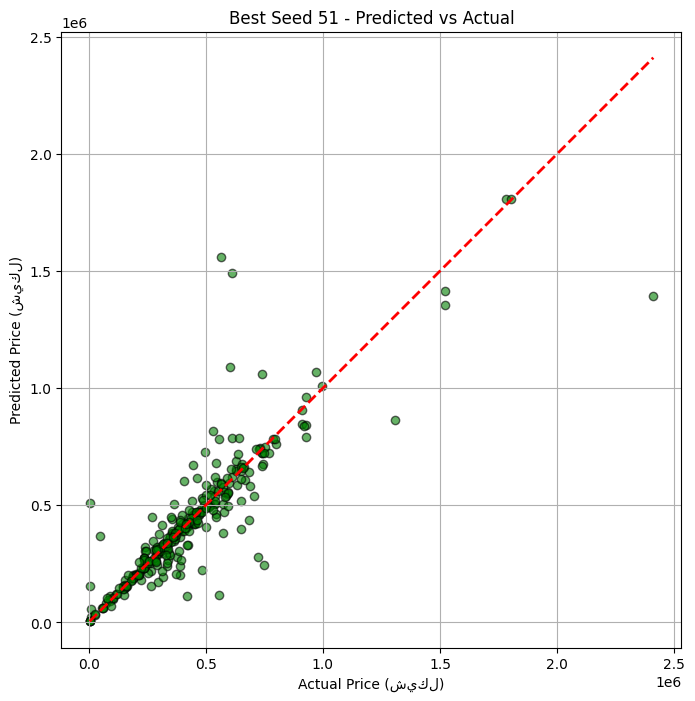

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


def inverse_transform(y_t):
    y_t = np.clip(y_t, a_min=0, a_max=None)
    return np.power(y_t, 1 / 0.4)


df = pd.read_csv("Augmented_Data.csv", index_col=0)

X = df.drop(columns=['price_trans', 'السعر بالشيكل', 'مساحة البناء'])
X = pd.get_dummies(X, columns=['المدينة'], drop_first=True)

y_trans = df['price_trans']
y_orig = df['السعر بالشيكل']

model_params = dict(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    verbosity=0
)


random.seed(42)     
np.random.seed(42)  

random_seeds = random.sample(range(50, 100), 10)
results = []

for seed in random_seeds:
    # Split
    X_train, X_test, y_train_t, y_test_t, y_train_o, y_test_o = train_test_split(
        X, y_trans, y_orig, test_size=0.2, random_state=seed, shuffle=True
    )

    # CV
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_r2_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train_t.iloc[train_idx], y_train_t.iloc[val_idx]
        y_val_orig = y_train_o.iloc[val_idx]
        
        model = XGBRegressor(**model_params, random_state=seed)
        model.fit(X_tr, y_tr)
        
        y_val_pred_t = model.predict(X_val)
        y_val_pred_o = inverse_transform(y_val_pred_t)
        
        cv_r2_scores.append(r2_score(y_val_orig, y_val_pred_o))

    cv_mean_r2 = np.mean(cv_r2_scores)

    # Train final model for test set
    final_model = XGBRegressor(**model_params, random_state=seed)
    final_model.fit(X_train, y_train_t)

    y_test_pred_t = final_model.predict(X_test)
    y_test_pred_o = inverse_transform(y_test_pred_t)

    test_r2 = r2_score(y_test_o, y_test_pred_o)
    gap = abs(test_r2 - cv_mean_r2)
    combined_score = cv_mean_r2 - gap

    results.append({
        "seed": seed,
        "cv_r2": cv_mean_r2,
        "test_r2": test_r2,
        "gap": gap,
        "combined_score": combined_score,
        "y_test_o": y_test_o,
        "y_test_pred_o": y_test_pred_o,
        "model": final_model
    })

    print(f"Seed {seed}: CV R2={cv_mean_r2:.4f}, Test R2={test_r2:.4f}, "
          f"Gap={gap:.4f}, Combined={combined_score:.4f}")


best_result = max(results, key=lambda r: r["combined_score"])
best_seed = best_result["seed"]
final_model = best_result["model"]  # trained model for best seed

print("\nBest Seed:", best_seed)
print(f"CV mean R2: {best_result['cv_r2']:.4f}")
print(f"Test R2: {best_result['test_r2']:.4f}")
print(f"Gap: {best_result['gap']:.4f}")
print(f"Combined score: {best_result['combined_score']:.4f}")


plt.figure(figsize=(8, 8))
plt.scatter(best_result["y_test_o"], best_result["y_test_pred_o"],
            alpha=0.6, color='green', edgecolor='k')
plt.plot([best_result["y_test_o"].min(), best_result["y_test_o"].max()],
         [best_result["y_test_o"].min(), best_result["y_test_o"].max()],
         'r--', lw=2)
plt.xlabel('Actual Price (شيكل)')
plt.ylabel('Predicted Price (شيكل)')
plt.title(f'Best Seed {best_seed} - Predicted vs Actual')
plt.grid(True)
plt.axis('equal')
plt.show()


In [13]:
def predict_price(model, input_row, city_categories):
    
    # Convert input to DataFrame with one row
    df_input = pd.DataFrame([input_row])

    # One-hot encode المدينة with the same categories as training (drop_first=True)
    for city in city_categories:
        col_name = f'المدينة_{city}'
        df_input[col_name] = (df_input['المدينة'] == city).astype(int)
    df_input = df_input.drop(columns=['المدينة'])

    # Reorder columns to match training features order
    # (Assuming you have 'X.columns' from training data)
    df_input = df_input.reindex(columns=X.columns, fill_value=0)

    # Predict transformed price
    y_pred_trans = model.predict(df_input)[0]

    # Inverse transform to original price scale
    y_pred_orig = inverse_transform(y_pred_trans)

    return y_pred_orig


In [18]:
# example
city_categories = [col.replace('المدينة_', '') for col in X.columns if col.startswith('المدينة_')]

example_input = {
    'عدد الغرف': 3,
    'عدد الحمامات': 2,
    'مفروشة': 0,
    'مساحة البناء': 125,
    'الطابق': 2,
    'عمر البناء': 0,
    'العقار مرهون': False,
    'طريقة الدفع': 2,
    'مصعد': False,
    'موقف سيارات': True,
    'المدينة': 'نابلس'
}

predicted_price = predict_price(final_model, example_input, city_categories)
print(f"Predicted Price (شيكل): {predicted_price:.2f}")

Predicted Price (شيكل): 191594.48
